In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.2"
import jax.numpy as jnp
import matplotlib.pyplot as plt
from backend import *
from jax import value_and_grad
import numpy as np
from jax import config
config.update('jax_platform_name', 'cpu')
from jax.lib import xla_bridge
device = xla_bridge.get_backend().platform
print(device)

Metal device set to: Apple M2 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

cpu


2024-08-21 22:09:17.438938: W pjrt_plugin/src/mps_client.cc:534] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!


In [2]:
def uniform_2D_pc_weights(npc, nact,seed=0,sigma=0.1, alpha=1,envsize=1):
    x = np.linspace(-envsize,envsize,int(npc**0.5))
    xx,yy = np.meshgrid(x,x)
    pc_cent = np.concatenate([xx.reshape(-1)[:,None],yy.reshape(-1)[:,None]],axis=1)
    pc_sigma = np.tile(np.eye(2),(npc,1,1))*sigma
    # pc_sigma = np.tile(np.ones([2,2]),(npc,1,1))*sigma
    pc_constant = np.ones(npc) * alpha
    actor_key, critic_key = random.split(random.PRNGKey(seed), num=2)
    return [jnp.array(pc_cent), jnp.array(pc_sigma), jnp.array(pc_constant), 
            1e-5 * random.normal(actor_key, (npc,nact)), 1e-5 * random.normal(critic_key, (npc,1))]


def predict_placecell(params, x):
    pc_centers, pc_sigmas, pc_constant, actor_weights,critic_weights = params
    npcs = params[0].shape[0]
    pcacts = []
    for n in range(npcs):
        diff = (x[:,None]-pc_centers[n][:,None])
        exponent = diff.T @ jnp.linalg.inv(pc_sigmas[n]) @ diff
        pcact = jnp.exp(-0.5*exponent) * pc_constant[n]**2
        pcacts.append(pcact)
    return jnp.vstack(pcacts)[:,0]

def compute_reward_prediction_error(rewards, values, gamma=0.95):
    new_values = jnp.concatenate([values[1:], jnp.array([[0]])])
    td = rewards + gamma * new_values - values
    return td


def td_loss(params, coords, actions, rewards, gamma, betas):
    aprobs = []
    values = []
    for coord in coords:
        pcact = predict_placecell(params, coord)
        aprob = predict_action(params, pcact)
        value = predict_value(params, pcact)
        aprobs.append(aprob)
        values.append(value)
    aprobs = jnp.array(aprobs)
    values = jnp.array(values)

    log_likelihood = jnp.log(aprobs) * actions  # log probability of action as policy
    tde = jnp.array(compute_reward_prediction_error(rewards[:,None], values, gamma))
    actor_loss = jnp.sum(log_likelihood * lax.stop_gradient(tde))  # log policy * discounted reward
    critic_loss = -jnp.sum(tde ** 2) # grad decent
    tot_loss = actor_loss + betas[0] * critic_loss
    return tot_loss

def predict_value(params, pcact):
    pc_centers, pc_sigmas, pc_constant, actor_weights,critic_weights = params
    value = jnp.matmul(pcact, critic_weights)
    return value


def predict_action(params, pcact, beta=2):
    pc_centers, pc_sigmas, pc_constant, actor_weights,critic_weights = params
    actout = jnp.matmul(pcact, actor_weights)
    aprob = nn.softmax(beta * actout)
    return aprob

@jit
def update_td_params(params, coords, actions, rewards, etas, gamma, betas):
    loss, grads = value_and_grad(td_loss)(params, coords,actions, rewards, gamma, betas)
    pc_centers, pc_sigmas, pc_constant, actor_weights,critic_weights = params
    dpcc, dpcs, dpca, dact, dcri = grads

    # + for gradient ascent
    pc_eta, sigma_eta,constant_eta, actor_eta, critic_eta = etas
    newpc_centers = pc_centers + pc_eta * dpcc
    newpc_sigma = pc_sigmas + sigma_eta * dpcs
    newpc_const = pc_constant + constant_eta * dpca
    newactor_weights = actor_weights + actor_eta * dact
    newcritic_weights = critic_weights + critic_eta * dcri  # gradient descent
    return [newpc_centers, newpc_sigma,newpc_const, newactor_weights,newcritic_weights], grads, loss


In [3]:
def learn_(params, reward, state, onehotg, gamma, etas,beta=2):
    pcact = predict_placecell(params, state)
    # newpcact = predict_placecell(params, newstate)
    value =  predict_value(params, pcact)
    # newvalue = predict_value(params, newpcact)
    td = compute_reward_prediction_error(reward[:,None], np.array([value]), gamma)[:,0]

    # td = (reward + gamma * newvalue - value)[0]
    aprob = predict_action(params, pcact)
    onehotg = onehotg[0]

    # get critic grads
    dcri =  pcact[:,None] * td

    # get actor grads
    decay = beta * (onehotg[:,None]- aprob[:,None])  # derived from softmax grads
    # decay = onehotg[:,None]  # foster et al. 2000 rule, simplified form of the derivative
    dact = (pcact[:,None] @ decay.T) * td

    # get phi grads: dp = phi' (W^actor @ act + W^critic) * td
    post_td = (params[3] @ decay + params[4]) * td

    npcs = params[0].shape[0]
    
    for n in range(npcs):
        dpcc = (post_td[n] * (pcact[n,None]) * ((state - params[0][n])/params[1]**2)[:,None])[:,0]  # grad for pc_cent
        dpcs = (post_td * (pcact[:,None]) * ((state - params[0])**2/params[1]**3)[:,None])[:,0]  # grad for pc_sigma
    dpca = (post_td * (pcact[:,None]) * (2 / params[2][:,None]))[:,0]  # grad for pc_constant

    grads = [dpcc, dpcs, dpca, dact, dcri]

    #update weights
    for p in range(len(params)):
        params[p] += etas[p] * grads[p]

    return params, grads, td

In [4]:
def learn(params, reward, state, onehotg, gamma, etas, beta=1):
    pc_centers, pc_sigmas, pc_constant, actor_weights, critic_weights = params
    pcact = predict_placecell(params, state)
    value = predict_value(params, pcact)
    td = compute_reward_prediction_error(reward[:, None], np.array([value]), gamma)[:, 0]
    
    # Predict action and calculate TD error
    aprob = predict_action(params, pcact)
    onehotg = onehotg[0]

    # Critic grads
    dcri = pcact[:, None] * td

    # Actor grads
    decay = beta * (onehotg[:, None] - aprob[:, None])  # derived from softmax grads
    dact = (pcact[:, None] @ decay.T) * td

    # Grads for field parameters
    post_td = (actor_weights @ decay + critic_weights) * td
    dpcc = np.zeros_like(pc_centers)
    dpcs = np.zeros_like(pc_sigmas)
    dpca = np.zeros_like(pc_constant)

    for n in range(params[0].shape[0]):
        diff = state - pc_centers[n]
        inv_sigma = np.linalg.inv(pc_sigmas[n])
        exp_term = np.exp(-0.5 * diff.T @ inv_sigma @ diff)
        
        # Gradient wrt. pc_cent
        dpcc[n] = post_td[n] * pc_constant[n]**2 * exp_term * inv_sigma @ diff
        
        # Gradient wrt. pc_sigma
        diff_outer = np.outer(diff, diff)
        dpcs[n] = 0.5 * post_td[n] * pc_constant[n]**2 * exp_term * inv_sigma @ diff_outer @ inv_sigma
        
        # Gradient wrt. pc_constant
        dpca[n] = 2 * pc_constant[n] * exp_term * post_td[n]

    # Update parameters
    pc_eta, sigma_eta, constant_eta, actor_eta, critic_eta = etas
    new_pc_centers = pc_centers + pc_eta * dpcc
    new_pc_sigma = pc_sigmas + sigma_eta * dpcs
    new_pc_const = pc_constant + constant_eta * dpca
    new_actor_weights = actor_weights + actor_eta * dact
    new_critic_weights = critic_weights + critic_eta * dcri

    new_params = [new_pc_centers, new_pc_sigma, new_pc_const, new_actor_weights, new_critic_weights]
    grads = [dpcc, dpcs, dpca, dact, dcri]

    return new_params, grads, td

In [5]:
# gradients computed by jax

npc = 9
nact = 4
seed = 2020
sigma = 0.25
alpha = 1.0
envsize=1.0
gamma= 0.6

# model 
params = uniform_2D_pc_weights(npc, nact, seed, sigma=sigma, alpha=alpha, envsize=envsize)
#params[3] /=params[3]
#params[4] /=params[4]
#params[4] *= 1
etas = [1, 1, 1, 1, 1]
betas = [0.5]

# dataset
coords = np.array([[0.0, 0.0]])
rewards = np.array([1.0])
actions = np.array([[0,1,0,0]])


In [6]:
params[1]

Array([[[0.25, 0.  ],
        [0.  , 0.25]],

       [[0.25, 0.  ],
        [0.  , 0.25]],

       [[0.25, 0.  ],
        [0.  , 0.25]],

       [[0.25, 0.  ],
        [0.  , 0.25]],

       [[0.25, 0.  ],
        [0.  , 0.25]],

       [[0.25, 0.  ],
        [0.  , 0.25]],

       [[0.25, 0.  ],
        [0.  , 0.25]],

       [[0.25, 0.  ],
        [0.  , 0.25]],

       [[0.25, 0.  ],
        [0.  , 0.25]]], dtype=float32)

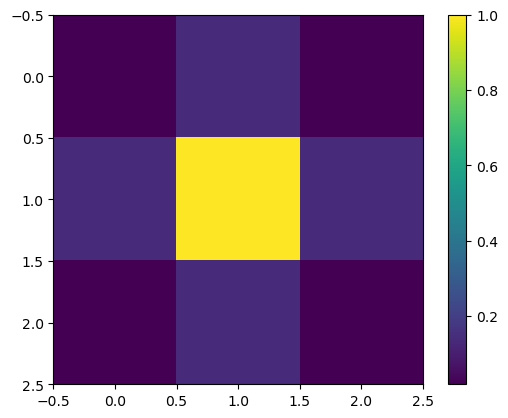

In [7]:
pc = predict_placecell(params, coords[0])
plt.imshow(pc.reshape(int(np.sqrt(npc)),int(np.sqrt(npc))))
plt.colorbar()

In [8]:
# update by jax
_, jaxgrads, loss = update_td_params(params.copy(), coords, actions, rewards, etas, gamma, betas)
print(loss)

for g in jaxgrads: print(g)

-1.8863151
[[-1.3908466e-06 -1.3908466e-06]
 [ 0.0000000e+00  3.1785319e-06]
 [-2.9516998e-06  2.9516998e-06]
 [ 1.0359796e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00]
 [-6.5796089e-06  0.0000000e+00]
 [-3.7933916e-07  3.7933916e-07]
 [ 0.0000000e+00  1.6682028e-05]
 [-3.4374136e-08 -3.4374136e-08]]
[[[-2.7816932e-06 -2.7816932e-06]
  [-2.7816932e-06 -2.7816932e-06]]

 [[ 0.0000000e+00  0.0000000e+00]
  [ 0.0000000e+00  6.3570637e-06]]

 [[ 5.9033996e-06 -5.9033996e-06]
  [-5.9033996e-06  5.9033996e-06]]

 [[ 2.0719592e-05  0.0000000e+00]
  [ 0.0000000e+00  0.0000000e+00]]

 [[ 0.0000000e+00  0.0000000e+00]
  [ 0.0000000e+00  0.0000000e+00]]

 [[ 1.3159218e-05  0.0000000e+00]
  [ 0.0000000e+00  0.0000000e+00]]

 [[-7.5867831e-07  7.5867831e-07]
  [ 7.5867831e-07 -7.5867831e-07]]

 [[ 0.0000000e+00  0.0000000e+00]
  [ 0.0000000e+00 -3.3364056e-05]]

 [[ 6.8748271e-08  6.8748271e-08]
  [ 6.8748271e-08  6.8748271e-08]]]
[-6.9542330e-07  1.5892659e-06  1.4758499e-06  5.1798979e-06


In [9]:
jaxgrads[1].shape

(9, 2, 2)

In [10]:
# update by numpy
_, npgrads, td = learn(params.copy(), rewards, coords[0], actions, gamma, etas)
print(td)

for g in npgrads: print(g)

[0.999997]
[[-1.3908466e-06 -1.3908466e-06]
 [ 0.0000000e+00  3.1785319e-06]
 [-2.9516993e-06  2.9516993e-06]
 [ 1.0359796e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00]
 [-6.5796089e-06  0.0000000e+00]
 [-3.7933918e-07  3.7933918e-07]
 [ 0.0000000e+00  1.6682028e-05]
 [-3.4374168e-08 -3.4374168e-08]]
[[[-2.7816932e-06 -2.7816932e-06]
  [-2.7816932e-06 -2.7816932e-06]]

 [[ 0.0000000e+00  0.0000000e+00]
  [ 0.0000000e+00  6.3570637e-06]]

 [[ 5.9033987e-06 -5.9033987e-06]
  [-5.9033987e-06  5.9033987e-06]]

 [[ 2.0719592e-05  0.0000000e+00]
  [ 0.0000000e+00  0.0000000e+00]]

 [[ 0.0000000e+00  0.0000000e+00]
  [ 0.0000000e+00  0.0000000e+00]]

 [[ 1.3159218e-05  0.0000000e+00]
  [ 0.0000000e+00  0.0000000e+00]]

 [[-7.5867837e-07  7.5867837e-07]
  [ 7.5867837e-07 -7.5867837e-07]]

 [[ 0.0000000e+00  0.0000000e+00]
  [ 0.0000000e+00 -3.3364056e-05]]

 [[ 6.8748335e-08  6.8748335e-08]
  [ 6.8748335e-08  6.8748335e-08]]]
[-6.9542330e-07  1.5892659e-06  1.4758497e-06  5.1798979e-06


In [19]:
idx = 7
pidx = 1
print(np.array(jaxgrads[pidx])[idx])
print(np.array(npgrads[pidx])[idx])
print(np.array(jaxgrads[pidx])[idx] /np.array(npgrads[pidx])[idx])


[[ 0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -3.3364056e-05]]
[[ 0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -3.3364056e-05]]
[[nan nan]
 [nan  1.]]


/var/folders/9w/2t7dk80j0vncsnz93dbrg1080000gp/T/ipykernel_17700/3206922972.py:5: RuntimeWarning: invalid value encountered in divide
  print(np.array(jaxgrads[pidx])[idx] /np.array(npgrads[pidx])[idx])


In [12]:
idx = 2
pidx = 2
print(np.array(jaxgrads[pidx])[idx])
print(np.array(npgrads[pidx])[idx])
print(np.array(jaxgrads[pidx])[idx] /np.array(npgrads[pidx])[idx])


1.4758499e-06
1.4758497e-06
1.0000001
